In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [3]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,),),                
           ])

train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

Необязательное задание. Обучить автокодировщик на изображениях с обнуленными пикселями.

In [4]:
def zero_pixels(x, num=0.3):
    f = x.view(28*28)
    ids = np.random.choice(28*28, int(num*28*28), replace=False)
    f[ids] = 0
    f = f.view((1,28,28))    
    return f
    
def zero_batch(batch, num=0.3):
    batch_z = batch.clone().detach()
    for i in range(batch_z.shape[0]):
        batch_z[i] = zero_pixels(batch_z[i], num=num)
    return batch_z

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [6]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        
        D_KL(P||Q)_optim = -p*log(p^) - (1-p)log(1-p^)
        """
        #dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
        dkl = - rho * torch.log(self.data_rho) - (1-rho)*torch.log(1-self.data_rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [7]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(zero_batch(data))
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [8]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'rho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(zero_batch(data)) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
                rho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], rho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

Испытания моделей с разным learning rate.

In [10]:
models = {'64, e-3': Net(latent_size=64, lr=1e-3),
          '64, e-4': Net(latent_size=64, lr=1e-4),
          '64, e-5': Net(latent_size=64, lr=1e-5)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [11]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 64, e-3: 0.972560 64, e-4: 1.030332 64, e-5: 1.025576
Train Epoch: 1 [10000/50000 (20%)]	Losses 64, e-3: 0.230199 64, e-4: 0.732300 64, e-5: 0.923499
Train Epoch: 1 [20000/50000 (40%)]	Losses 64, e-3: 0.177849 64, e-4: 0.468821 64, e-5: 0.882772
Train Epoch: 1 [30000/50000 (60%)]	Losses 64, e-3: 0.146753 64, e-4: 0.379028 64, e-5: 0.864621
Train Epoch: 1 [40000/50000 (80%)]	Losses 64, e-3: 0.136853 64, e-4: 0.338715 64, e-5: 0.851499
Train Epoch: 1 [50000/50000 (100%)]	Losses 64, e-3: 0.111879 64, e-4: 0.300292 64, e-5: 0.845981
Test set:
64, e-3: loss: 0.1228	rho_loss: 0.0044
64, e-4: loss: 0.3075	rho_loss: 0.0059
64, e-5: loss: 0.8430	rho_loss: 0.0048

Train Epoch: 2 [0/50000 (0%)]	Losses 64, e-3: 0.120425 64, e-4: 0.306888 64, e-5: 0.844023
Train Epoch: 2 [10000/50000 (20%)]	Losses 64, e-3: 0.120036 64, e-4: 0.298594 64, e-5: 0.827840
Train Epoch: 2 [20000/50000 (40%)]	Losses 64, e-3: 0.106128 64, e-4: 0.259616 64, e-5: 0.814458
Train Epoch: 2 [3

Train Epoch: 12 [50000/50000 (100%)]	Losses 64, e-3: 0.061735 64, e-4: 0.102183 64, e-5: 0.240149
Test set:
64, e-3: loss: 0.0631	rho_loss: 0.0041
64, e-4: loss: 0.1022	rho_loss: 0.0042
64, e-5: loss: 0.2415	rho_loss: 0.0053

Train Epoch: 13 [0/50000 (0%)]	Losses 64, e-3: 0.065044 64, e-4: 0.102507 64, e-5: 0.239429
Train Epoch: 13 [10000/50000 (20%)]	Losses 64, e-3: 0.059261 64, e-4: 0.097657 64, e-5: 0.237988
Train Epoch: 13 [20000/50000 (40%)]	Losses 64, e-3: 0.056818 64, e-4: 0.094838 64, e-5: 0.238277
Train Epoch: 13 [30000/50000 (60%)]	Losses 64, e-3: 0.062707 64, e-4: 0.103612 64, e-5: 0.246875
Train Epoch: 13 [40000/50000 (80%)]	Losses 64, e-3: 0.071285 64, e-4: 0.116925 64, e-5: 0.254639
Train Epoch: 13 [50000/50000 (100%)]	Losses 64, e-3: 0.065464 64, e-4: 0.102495 64, e-5: 0.239473
Test set:
64, e-3: loss: 0.0618	rho_loss: 0.0041
64, e-4: loss: 0.0994	rho_loss: 0.0042
64, e-5: loss: 0.2331	rho_loss: 0.0051

Train Epoch: 14 [0/50000 (0%)]	Losses 64, e-3: 0.061593 64, e-4: 0.1

In [16]:
data, _ = next(iter(test_loader))
data_z = zero_batch(data)
output = models['64, e-3'](data_z)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64, e-3'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64, e-3'].E(data_z.view(-1, 28*28))
    print((encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.
    decoded_f = models['64, e-3'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([0, 3, 0, 0, 1, 2, 0, 0, 2, 1, 1, 0, 1, 0, 1, 2, 1, 1, 2, 0, 1, 1, 1, 0,
        0, 3, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 1])


Хотя обе ошибки меньше при lr = 1e-3, качество изображений становится хуже. Переобучение?

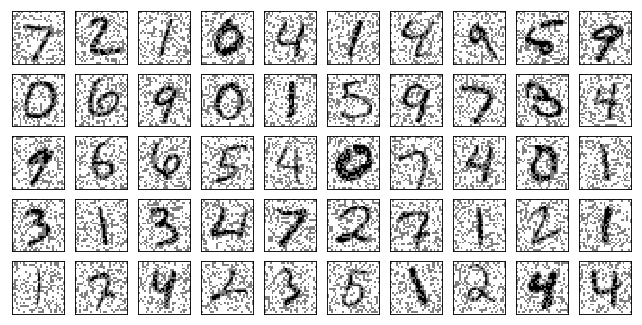

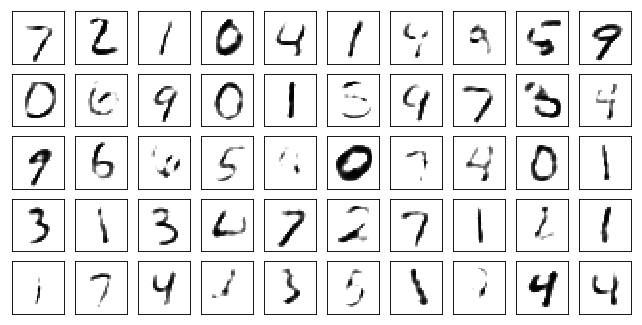

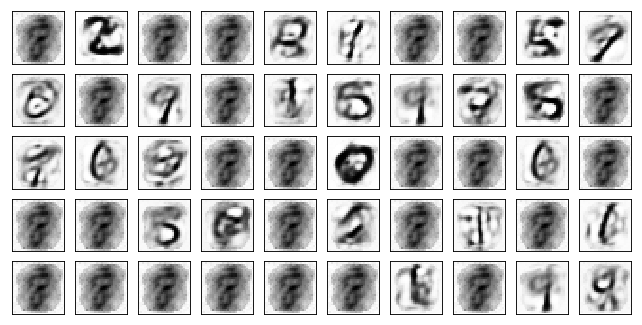

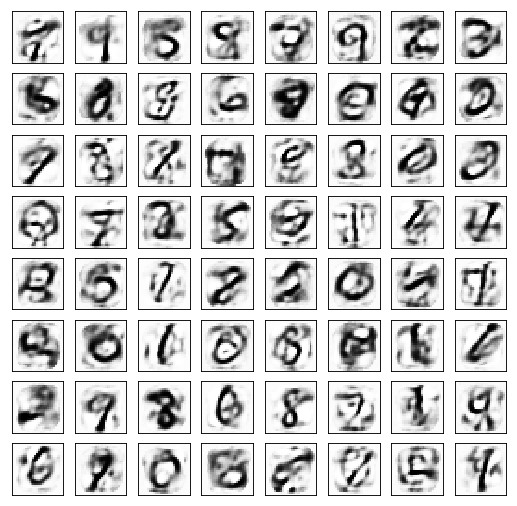

In [17]:
plot_mnist(data_z.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))